# CS525 FINAL PROJECT
### GROUP MEMBERS: Ted Monyak, Jack Forman
### GITHUB REPO: https://github.com/tedmonyak/CS525Arabidopsis
Please note that all the code to generate our data and models are in the repo



In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import json
import torch
# import logomaker

simplecnnDir = os.path.join(os.getcwd(), 'Model_SimpleCNN_Best')
deepcnnDir = os.path.join(os.getcwd(), 'Model_DeepCNN_Best')
transformerDir = os.path.join(os.getcwd(), 'Model_DNATranformer_Best')
deeptransformerDir = os.path.join(os.getcwd(), 'Model_DeepTransformer_Best')

dirs = [simplecnnDir, deepcnnDir, transformerDir]

# Introduction

Transcription factors (TFs) are one of the primary modes of gene regulation. When a TF binds to DNA, it may enhance, repress, or promote transcription - though it may only bind when chromatin is accessible. Each TF typically recognizes a particular DNA sequence, known as a binding motif, which averages approximately 10 nucleotides in length (Stewart et al. 2012).

Convolutional Neural Networks (CNNs) are a powerful tool for doing DNA sequence level prediction tasks, including predictions of chromatin accessibility (Kelley et al. 2016, 2018). The intuition is that a deep-CNN (with multiple layers of convolution) can learn higher-order representations of windows of DNA sequences, and predict a downstream task based on those representations.

ChIP-Seq is a widely used molecular biology technique for estimating chromatin accessibility (Valouev et al. 2008). It produces reads that are then mapped to a genome, which produces a coverage value for every spot on the genome. This read coverage is an estimation of chromatin accessibility. 


The goal of this project was to train a deep-CNN to predict chromatin accessibility in Arabidopsis (Arabidopsis thaliana), based on read coverage. We were able to train a model with reasonable performance, particularly in its ability to discern high read coverage from low read coverage, which suggests that this is a promising direction for research.

### Model Architectures

We experimented with numerous CNN-based models, to determine the effects of several hyperparameters and variations on architecture. Hyperparameters we looked at were: learning rate, learning rate decay, batch size. Architecture components we experimented with were: number of convolutional layers, convolutional filter size, number of convolutional filters, layers of prediction head, and whether a transformer processed the outputs from the convolutional layers.

We framed the model training task as a regression prediction task, where given a 2.5kb DNA sequence, the objective was to predict the mean chromatin coverage. Since we were predicting a continuous variable with an exponential distribution, we used a Poisson loss function, calculated as loss = exp(y_pred) - y_pred*y.

 In the simplest case—the **Simple CNN**—a single convolutional layer was followed by a fully connected layer. This minimal architecture offers advantages in terms of interpretability and computational efficiency. However, its simplicity may limit its ability to capture higher-order patterns in the sequence data that could be important for accurately modeling chromatin accessibility.

A more complex architecture—the **Deep CNN**—consisted of three convolutional layers followed by three fully connected layers. This model has significantly greater capacity to learn complex features and hierarchical patterns within the sequence data, while still retaining a relatively straightforward structure. Its depth allows it to capture more nuanced relationships that may be missed by simpler model.

The final architecture explored was a simple transformer-based model, referred to as the **DNA Transformer**. It consisted of three convolutional layers followed by a transformer block, which was then connected to a single linear output layer. This architecture is designed to capture both local and global patterns in the sequence data. The convolutional layers help extract localized features, while the transformer enables the model to learn long-range dependencies and higher-order structures that may be critical for understanding chromatin accessibility.

All of the source code for these models can be seen in SRC/Models



# Methods



### Data Preprocessing
First, we retrieved the reference TAIR10 Arabidopsis genome from EnsemblPlants. Next, we read in read coverage BED files from 37 Arabidopsis experiments. To pre-process our data, we segmented the sequence data into 2.5kb bins overlapping every 1.25kb, and converted them into one-hot encodings. For each 2.5kb bin, we summarized the mean coverage data using PyBigWig (Github) for each experiment, resulting in 37 coverage datapoints for each DNA sequence. We pre-processed each datapoint further by adding 1 to it and taking the natural log, thus transforming the data into the range [0, 6]. This was warranted due to the fact that there was an exponential distribution of the input data, with the majority of the data having low coverage, and relatively few sequences with high coverage. Chromosomes 1-4 were used for training and validation, and chromosome 5 was held out to create a test dataset.

To download and parse data use Notebooks/StartUp.ipynb

# Results

### Training



Training of DNA models is difficult. For reasonable preforming models large computational resources are need, due to this limitation we had to limit the number of filters used which may have decreased the bandwidth of the motifs that our models could find. Additionally, parameter initialization leads to random parameters that happen to not train correctly leading to having to train the same model multiple times. Early stopping algorithms were implemented, but most were trained by eye. The loss curves below show some of this difficulty, the validation loss started higher then the training loss for many of our models and eventually cross. Typically a few epochs after that the validation and training losses would diverge and early stopping would be implemented.


All training was done in Notebooks/Train_***.ipynb

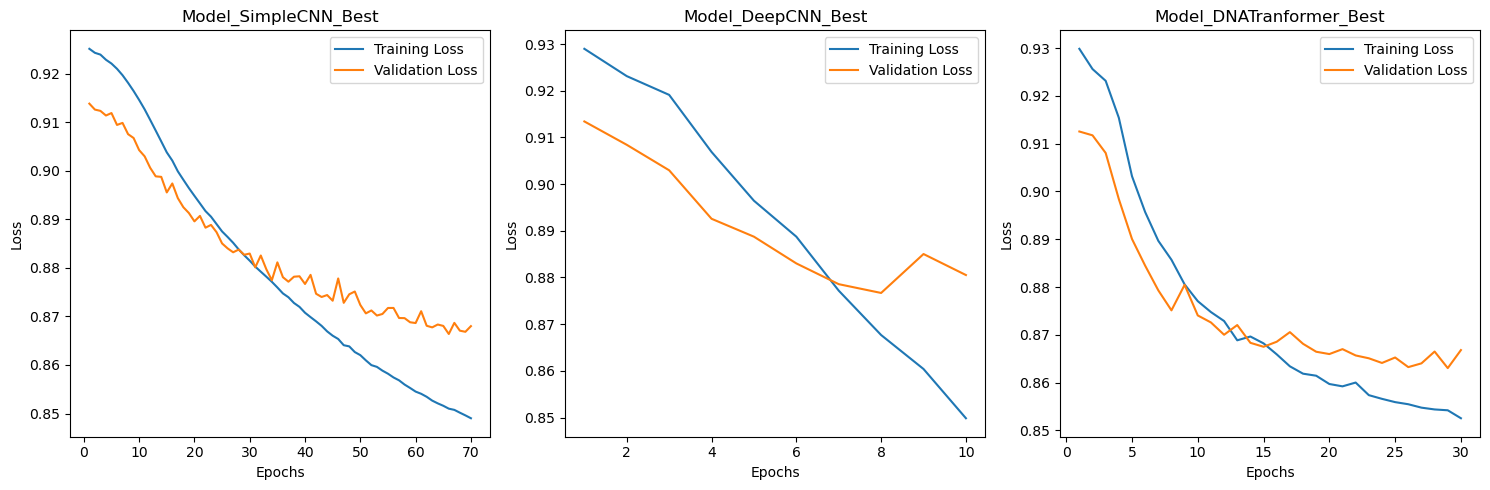

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, dir in enumerate(dirs):
    # Load the data
    with open(os.path.join(dir, 'losses.json'), 'r') as f:
        losses = json.load(f)

    train_loss = losses['train_loss']
    val_loss = losses['validation_loss']

    # Extract the data

    epochs = list(range(1, len(train_loss) + 1))

    # Plot the data
    ax[i].plot(epochs, train_loss, label='Training Loss')
    ax[i].plot(epochs, val_loss, label='Validation Loss')
    ax[i].set_title(os.path.basename(dir))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].legend()
plt.tight_layout()
plt.show()


In [3]:
# Params are in the model folder under the name model_parameters.json
for i, dir in enumerate(dirs):
    # Load the data
    with open(os.path.join(dir, 'model_parameters.json'), 'r') as f:
        params = json.load(f)
        param_text = "\n".join([f"{key}: {value}" for key, value in params.items()])
        print(f"Model: {os.path.basename(dir)}")
        print(param_text)
        print("-" * 40)


Model: Model_SimpleCNN_Best
num_kernels: [256]
kernel_size: [24]
dropout: 0.1
----------------------------------------
Model: Model_DeepCNN_Best
num_kernels: [512, 128, 64]
kernel_size: [24, 4, 4]
dropout: 0.2
flatten_shape: 19648
connect_layer_size: [120, 80]
----------------------------------------
Model: Model_DNATranformer_Best
num_kernels: [64, 64, 64]
kernel_size: [24, 16, 8]
dropout: 0.2
num_tranformer_heads: 4
num_transformer_layers: 3
----------------------------------------


### Accuracy 
<style>
img {
    display: block;
    margin-left: 0;
    margin-right: auto;
    width: 30%;
    height: 30%;
}
</style>


The accuracy graphs provide insight into how well each model learns and generalizes to the data. Accuracy evaluated on the training set shows that the models are learning meaningful patterns without simply memorizing the data, as evidenced by their predictions not perfectly following the *y = x* line which would indicate overfitting and perfect recall of the training data. This diagonal line represents ideal predictions with perfect knowledge of the input-output relationship.

In addition, the Pearson correlation coefficient is used to assess how well the predicted values correlate with the experimental (ground truth) data. A value of 1 indicates perfect linear correlation.


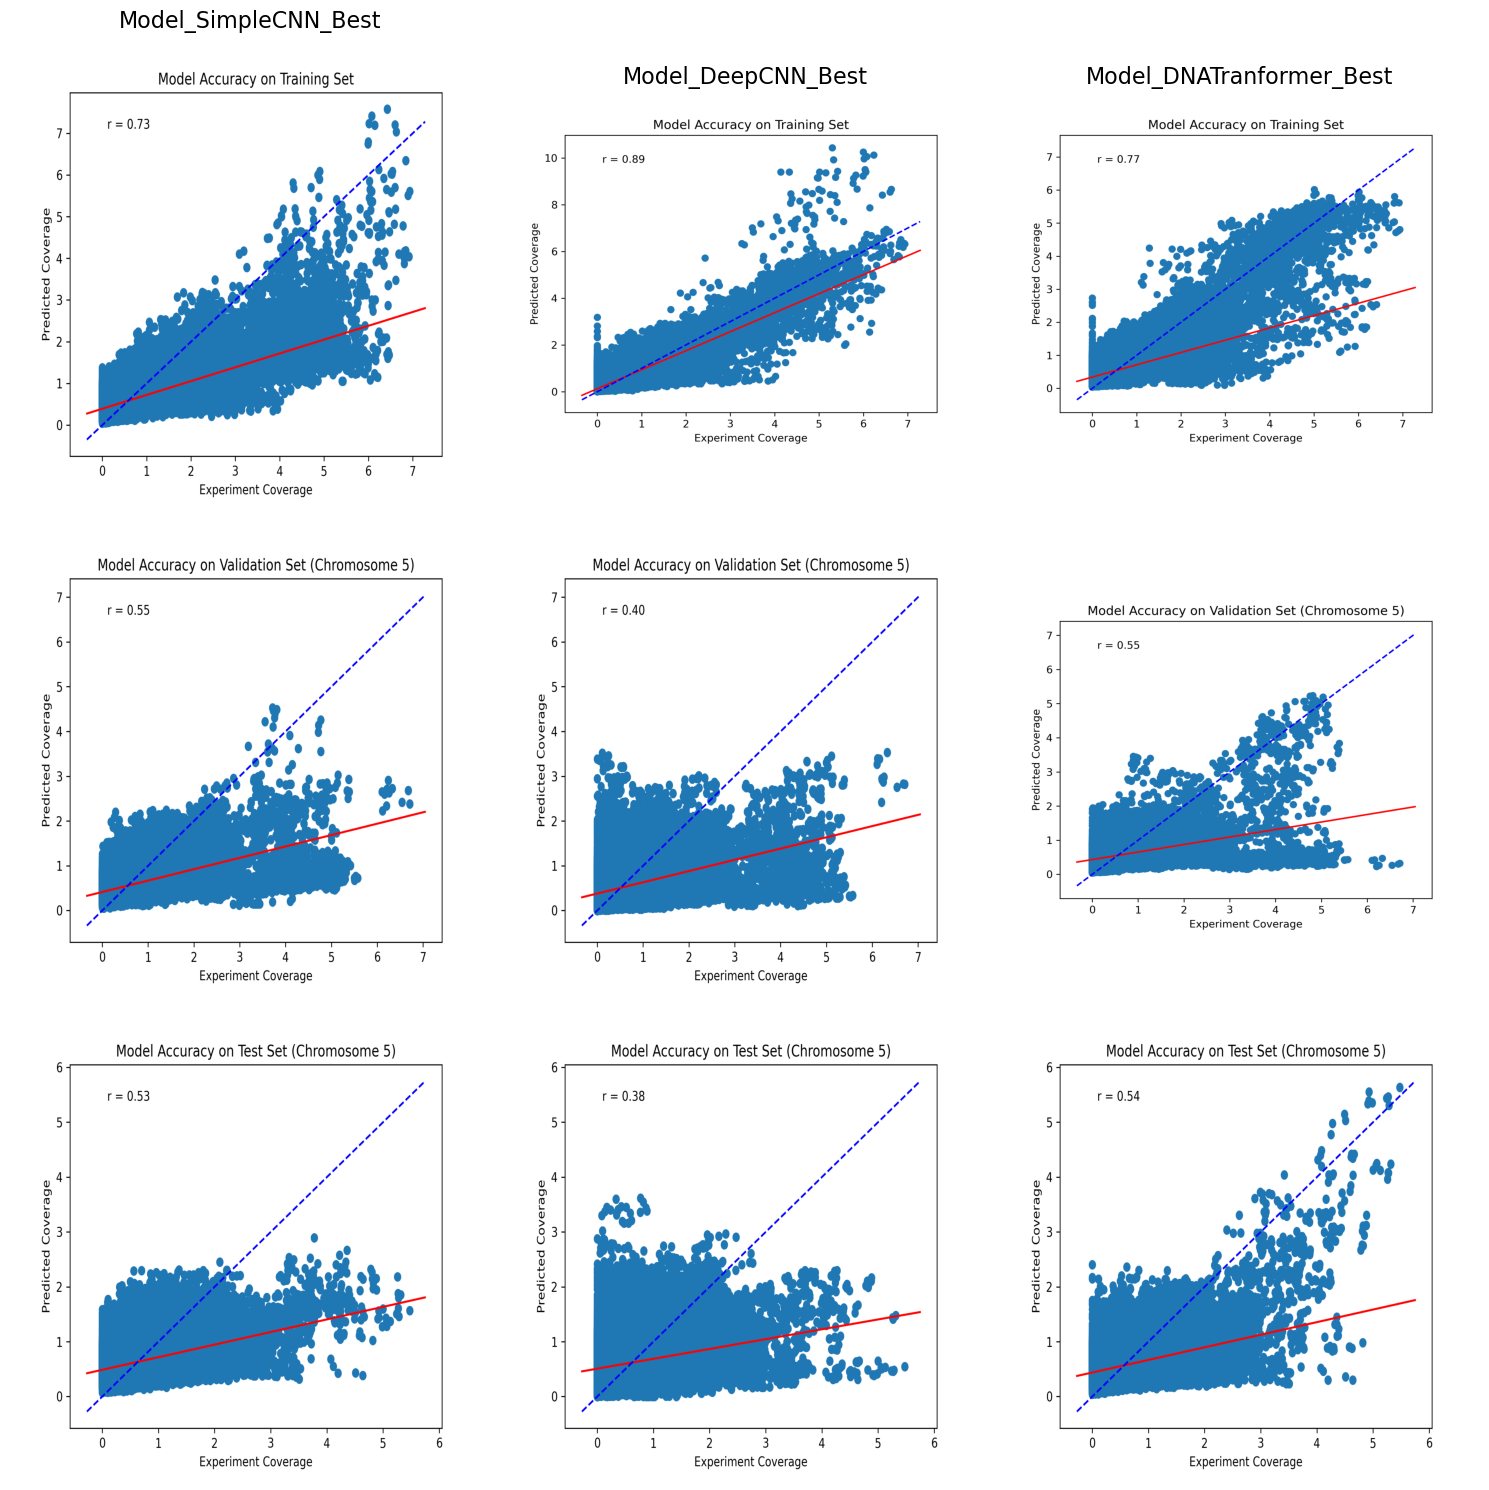

In [4]:
from matplotlib.image import imread

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, dir in enumerate(dirs):
    ax[0, i].imshow(imread(os.path.join(dir, 'TrainingAccuracy.png')))
    ax[0, i].set_title(os.path.basename(dir), fontsize=16)
    ax[1, i].imshow(imread(os.path.join(dir, 'ValAccuracy.png')))
    ax[2, i].imshow(imread(os.path.join(dir, 'TestingAccuracy.png')))

    for j in range(3):
        ax[i, j].axis('off')
        ax[i, j].set_aspect('auto')

plt.tight_layout()
plt.show()


Among the models, the **Simple CNN** performs worse on the training data compared to more complex architectures. However, it shows strong generalization to both the validation and testing datasets, suggesting that its simplicity helps prevent overfitting and allows it to capture robust, generalizable features.


We were able to train **DNA Transformer** to a Pearson R of 0.54 on the test set. While this is promising, one major caveat is that the data is significantly clustered in the lower bound of the range, which may inflate the correlation score. With accessibility prediction, it is more important to predict the directionality (i.e. open / closed) chromatin than the actual coverage value, as this may be an experimental artifact with limited biological significance. As such, it is encouraging that at the upper range of the experimental coverage, our model is able to predict high coverage (the upper right of figure 1), and there are no cases in which our model predicts very high coverage for sequences with low experimental coverage. There is a great deal of noise, particularly towards the bottom end of the range, but this is likely due to our model not having enough convolutional filters and/or parameters. In the bottom right of the figure, we do see that there are many “false negatives” where low coverage is predicted on sequences with high coverage. We can hypothesize that this is due to TF binding sites that are present in chromosome 5 but not present in other chromosomes.


### Filters

The first convolutional model in a DNA CNN model reads raw, one-hot encodings of the DNA sequence, so there is some intuition that the filters from the first layer may be recognizing TF-binding motifs. We know that due to the depth of the model, this is not actually the case, but in any case, it is sometimes helpful to investigate the weights on the convolutional filters to try to determine whether any TF-binding motifs have been identified by any of the filters. We ran this analysis by pulling each of the convolutional filter weights fron the first layer, and finding the filter with the lowest entropy score, calculated as the sum of -p*log(p) for each nucleotide in [A, C, G, T]. The lowest entropy score corresponds with the highest amount of information contained in a filter. The filter with the lowest entropy score was pulled out and examined, but there was no clear signal of any sequence of nucleotides that the model had learned to recognize. We can infer from this that the model is sufficiently deep that the information contained in the filter weights has low interpretability.


/home/formanj/miniconda3/envs/ImgProc_GPU_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1488031/3783991706.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allo

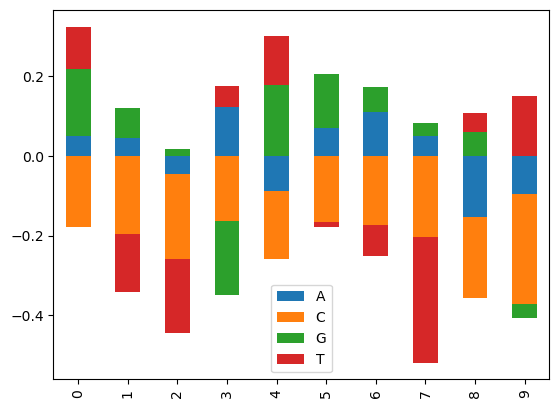

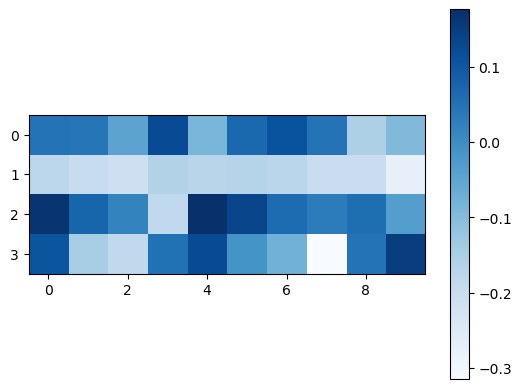

In [5]:
from src import DeepTransformer
model = DeepTransformer()
model = torch.load(os.path.join(deeptransformerDir, 'model.pth'))

def calc_entropy(row):
    H = 0
    for n in ['A', 'C', 'G', 'T']:
        H -= row[n] * math.log(row[n])
    return H

def create_profile_logo(motif_probs):
    """
    Creates a profile logo based on the motif probabilities

    parameters:
    motif_probs: a 2D array, with dims [k, 4], populated with
    the probabilities of each nucleotide at each position

    Displays the profile logo
    """
    mat = pd.DataFrame(motif_probs)
    mat.columns = ['A', 'C', 'G', 'T']
    logomaker.Logo(mat)

weights=model.conv_block[0].weight.detach().cpu().numpy()
max_h = 0
max_i = 0
for i in range(len(weights)) :
    motif = pd.DataFrame(weights[i].T, columns=['A','C','G','T']).abs()
    motif['entropy'] = motif.apply(calc_entropy, axis=1)
    total_entropy = motif['entropy'].sum()
    if total_entropy > max_h:
        max_h = total_entropy
        max_i = i

motif = pd.DataFrame(weights[max_i].T, columns=['A','C','G','T'])
motif.plot.bar(stacked=True, use_index=True)

fig = plt.figure()
plt.imshow(weights[max_i],cmap="Blues")
plt.colorbar()

# create_profile_logo(motif.abs())

### Gene Difference in Tissues

To examine the biological relevance and generalizability of our models, we curated an additional dataset from [Ensembl Plants](https://ftp.ensemblgenomes.ebi.ac.uk/pub/plants/release-61/fasta/arabidopsis_thaliana/pep/), consisting of approximately 27,000 protein-coding genes from the *Arabidopsis thaliana* genome. The aim of this dataset is to investigate the chromatin accessibility of these genes across various plant tissues. This is biologically significant, as different tissues express distinct sets of proteins, and gene accessibility plays a key regulatory role in this expression. 

We expect the results to reveal two main patterns:  
1. A core set of genes with consistent accessibility across all tissues  
2. A set of genes exhibiting tissue-specific accessibility profiles

After clustering the tissues and proteins consistently throughout the three models, several structure arise such as the upper band seen in the first two heatmaps corrisponding to genes that are accessible in all tissues. Additionally, there are several tissues with large sets of proteins that are not accessible. This is showing that the models are capturing biologically relevent data. If we had additional time we could have done some gene annotations on these clusters.

The **DNA Transformer** did not seem to capture the higher accessibility structure as the other models did. The transformer seemed to understand that different tissues have different accessiblity, however, failed to capture the gene specific differences

The code to generate this is in Notebooks/BiologicalExploration.ipynb

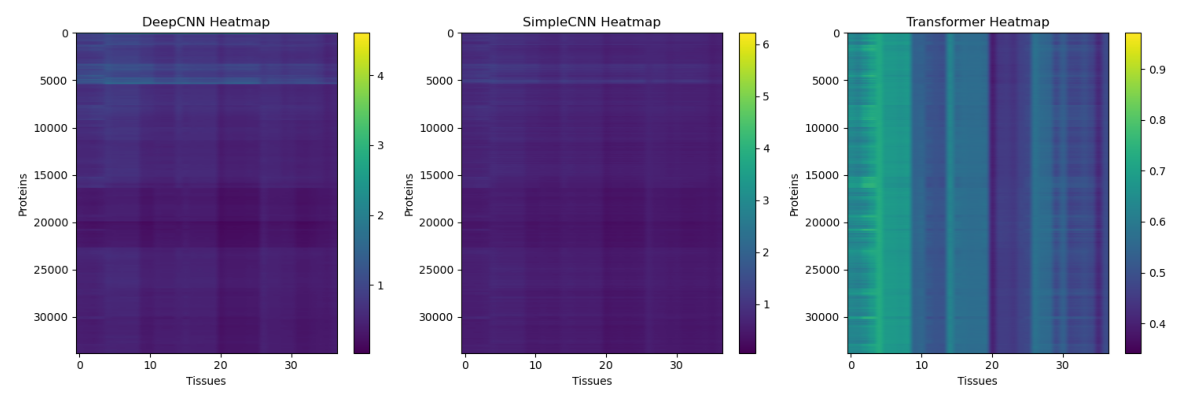

In [6]:
plt.figure(figsize=(15, 9))
plt.imshow(imread('AccessibilityHeatmap.png'))
plt.axis('off')
plt.show()

# Discussion

Our experiments reveal a promising direction to pursue for effective prediction of chromatin accessibility. 

There are some intriguing alternative architectures we would like to pursue if we are to try to improve performance further. The ResNet architecture enables residual connections between convolutional layers - where the input to layer n is passed directly to layer n+2, in addition to the convolved output of layer n+1 (He et al. 2006). This is of interest for our use-case, where the different representations of each layer could be passed directly to a transformer layer or the prediction head, to increase the expressivity of our model.

In this experiment, all of the data across the four tissue types (leaf, root, seed, flower) were merged together, and the model was trained on each of them in parallel. It may make sense in the future to try one of two approaches: a) aggregate experiments by tissue type and train a model with 4 prediction heads, and b) to train separate tissue-specific models. It is possible that the training task in this experiment was too broad to achieve good performance on limited compute.

It is estimated that there are 1500+ TFs in Arabidopsis (Qu and Zhu 2006). If we consider that to a first approximation, the convolutional filters in the first layer of our network learn to recognize TF binding sites, this suggests an upper bound for the number of convolutional filters we would like to use in a model. With more computing resources, this would be a worthwhile experiment to run.

Overall, this model had an acceptable performance, and was able to properly discern high read coverage from low read coverage, suggesting that it is possible to predict chromatin accessibility directly from DNA sequence information.


# References
Kelley, D. R., Snoek, J. & Rinn, J. L. Basset: learning the regulatory code of the accessible genome with deep convolutional neural networks. Genome Res. 26, 990–999 (2016).

Kelley, D. R. et al. Sequential regulatory activity prediction across chromosomes with convolutional neural networks. Genome Res. 28, 739–750 (2018).

He, K., Zhang, X., Ren, S. & Sun, J. Deep Residual Learning for Image Recognition. Preprint at https://doi.org/10.48550/arXiv.1512.03385 (2015).
Qu, L. J., & Zhu, Y. X. (2006). Transcription factor families in Arabidopsis: major progress and outstanding issues for future research. Current Opinion in Plant Biology, 9(5), 544-549.

Stewart, A. J., Hannenhalli, S., & Plotkin, J. B. (2012). Why transcription factor binding sites are ten nucleotides long. Genetics, 192(3), 973–985. https://doi.org/10.1534/genetics.112.143370

Valouev, A. et al. Genome-wide analysis of transcription factor binding sites based on ChIP-Seq data. Nat Methods 5, 829–834 (2008).


